In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import scipy
import skimage
import tifffile
from skimage.filters import sobel

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [ ]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="Patient ID to use for the segmentation",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        default=0.01,
        help="Clip limit for contrast limited adaptive histogram equalization",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    well_fov = args.well_fov
    patient = args.patient

else:
    well_fov = "C5-2"
    patient = "NF0014"
    clip_limit = 0.03

input_dir = pathlib.Path(f"../../data/{patient}/zstack_images/{well_fov}").resolve(
    strict=True
)

mask_path = pathlib.Path(f"../../data/{patient}/processed_data/{well_fov}").resolve()
mask_output = mask_path / "cell_masks_watershed.tiff"
mask_path.mkdir(exist_ok=True, parents=True)
nuclei_mask = tifffile.imread(
    pathlib.Path(
        f"../../data/{patient}/processed_data/{well_fov}/nuclei_masks_reconstructed_corrected.tiff"
    )
)

## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [4]:
# find the cytoplasmic channels in the image set
for f in files:
    if "555" in f:
        cyto2 = tifffile.imread(f)

# pick which channels to use for cellpose
cyto = skimage.exposure.equalize_adapthist(cyto2, clip_limit=clip_limit)

In [5]:
# gaussian filter to smooth the image
cyto = skimage.filters.gaussian(cyto, sigma=1.0)

In [ ]:
# scale the pixels to max 255
nuclei_mask = (nuclei_mask / nuclei_mask.max() * 255).astype(np.uint8)

In [7]:
# generate the elevation map using the Sobel filter
elevation_map = sobel(cyto)

In [8]:
# set up seeded watersheding where the nuclei masks are used as seeds
# note: the cytoplasm is used as the signal for this.

labels = skimage.segmentation.watershed(
    image=elevation_map,
    markers=nuclei_mask,
)

In [9]:
# change the largest label (by area) to 0
unique, counts = np.unique(labels, return_counts=True)
largest_label = unique[np.argmax(counts)]
labels[labels == largest_label] = 0

In [10]:
print(f"There are {len(np.unique(nuclei_mask))} nuclei in the mask")
print(f"There are {len(np.unique(labels))} cell masks in the watershed segmentation")

There are 8 nuclei in the mask
There are 7 cell masks in the watershed segmentation


In [11]:
# save the labels as a tiff file
tifffile.imwrite(mask_output, labels)

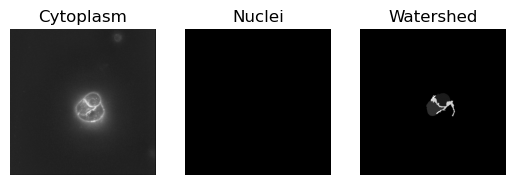

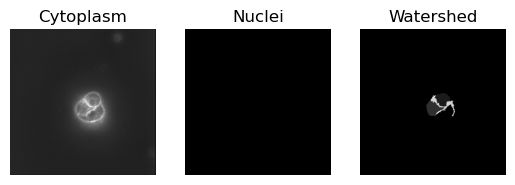

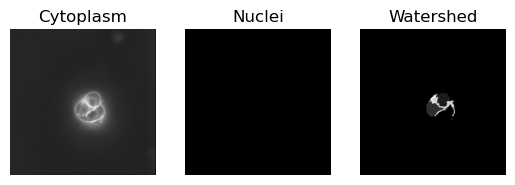

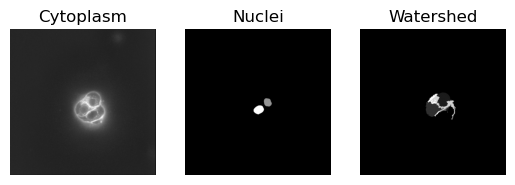

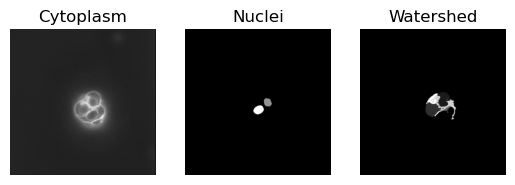

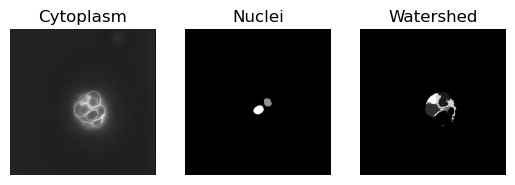

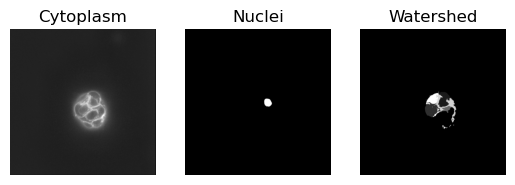

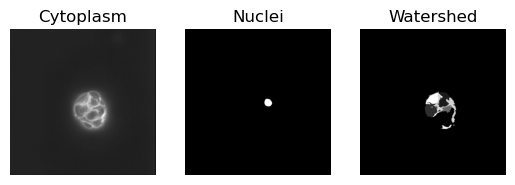

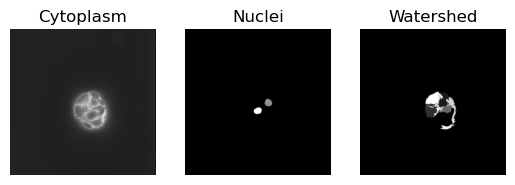

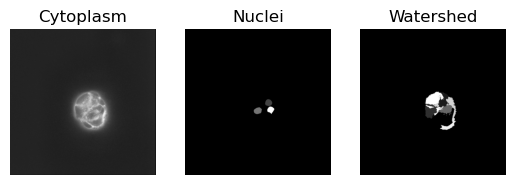

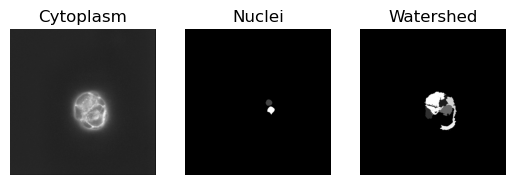

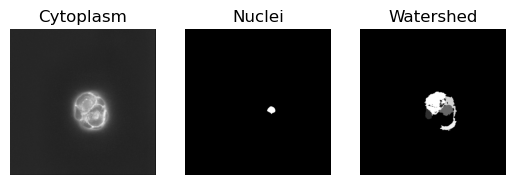

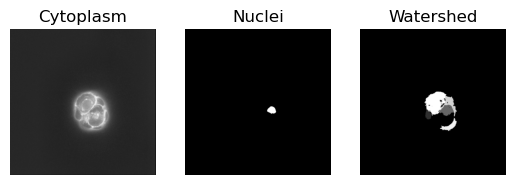

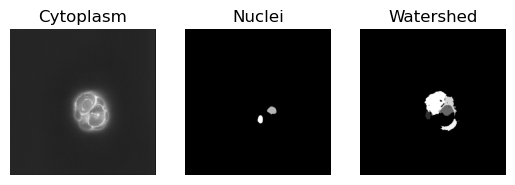

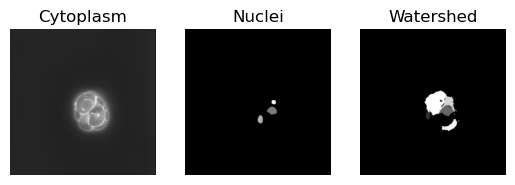

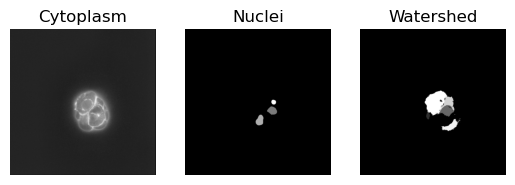

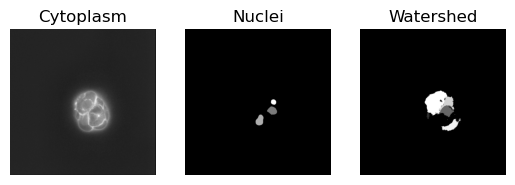

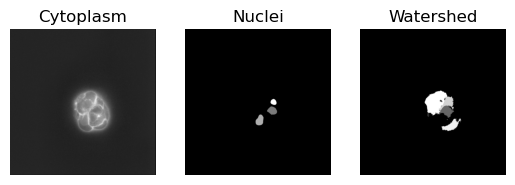

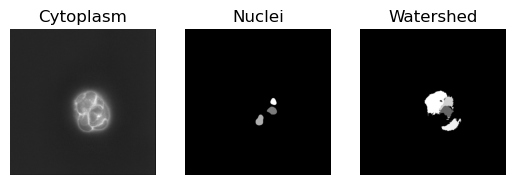

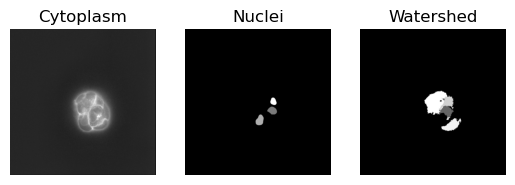

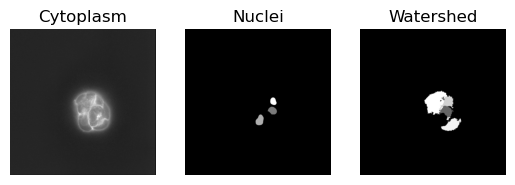

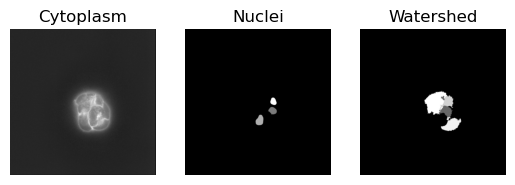

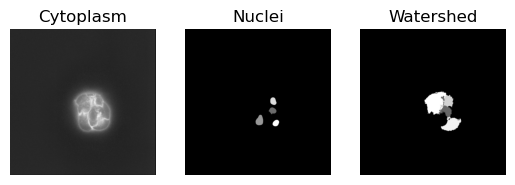

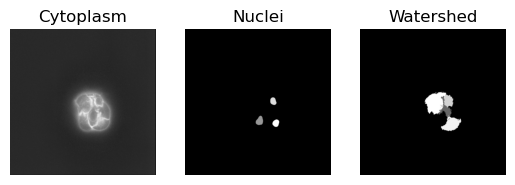

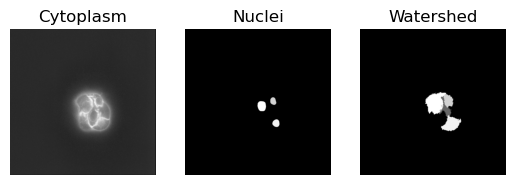

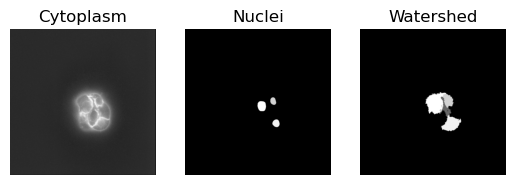

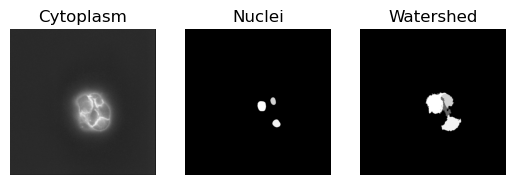

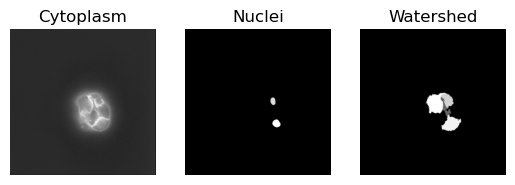

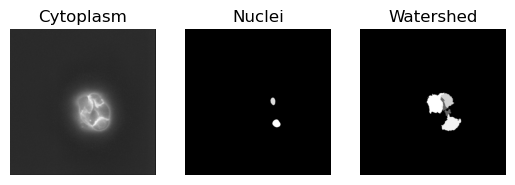

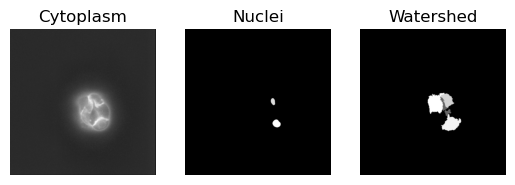

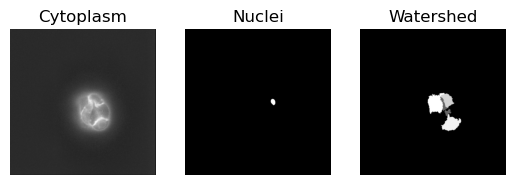

In [12]:
if in_notebook:
    for z in range(cyto.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(cyto[z, :, :], cmap="gray")
        plt.title("Cytoplasm")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(nuclei_mask[z, :, :], cmap="gray")
        plt.title("Nuclei")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(labels[z, :, :], cmap="gray")
        plt.title("Watershed")
        plt.axis("off")
        plt.show()